# Station Based data

## Imports

In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Functions

In [2]:
def extract_fwi_vars(df):
    df = df.copy()
    # 0) ensure these columns are strings (so split always works)
    for col in ['AA1','TMP','DEW','WND']:
        df[col] = df[col].fillna('').astype(str)

    # 1) split the AA1 and WND groups once
    aa1 = df['AA1'].str.split(',', expand=True)
    wnd = df['WND'].str.split(',', expand=True)

    # 2) precip (AA1 depth in tenths of mm; missing = 9999)
    depth = pd.to_numeric(aa1[1], errors='coerce')
    precip_mm = depth.where(depth != 9999, np.nan) / 10

    # 3) air temp (TMP signed tenths °C; missing = +9999)
    tmp_raw = df['TMP'].str.extract(r'([+-]?\d+)', expand=False)
    tmp_val = pd.to_numeric(tmp_raw, errors='coerce')
    air_C = tmp_val.where(tmp_val != 9999, np.nan) / 10

    # 4) dew point (DEW signed tenths °C; missing = +9999)
    dew_raw = df['DEW'].str.extract(r'([+-]?\d+)', expand=False)
    dew_val = pd.to_numeric(dew_raw, errors='coerce')
    dew_C = dew_val.where(dew_val != 9999, np.nan) / 10

    # 5) wind speed (WND 4th piece in tenths; missing = 9999)
    speed = pd.to_numeric(wnd[3], errors='coerce')
    wind_speed = speed.where(speed != 9999, np.nan) / 10

    # 6) bundle + parse DATE
    return pd.DataFrame({
        'DATE':       pd.to_datetime(df['DATE'], errors='coerce'),
        'air_C':      air_C,
        'dew_C':      dew_C,
        'wind_speed': wind_speed,
        'precip_mm':  precip_mm
    })


## Inputs

In [3]:
data_path = "/data/keeling/a/ctavila2/2024_FWI_CMIP5_Ensemble_Avila/data/lax_station.csv"
df = pd.read_csv(data_path, parse_dates=['DATE'])
fwi_df = extract_fwi_vars(df)

/tmp/ipykernel_116679/1706577137.py:2: DtypeWarning: Columns (6,12,13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path, parse_dates=['DATE'])


In [6]:
ds = xr.Dataset.from_dataframe(fwi_df)
ds['index'] = ds.DATE
ds = ds.rename({ 'index': 'time' })
daily_max = ds['air_C'].resample(time='1D').max() + 273.15

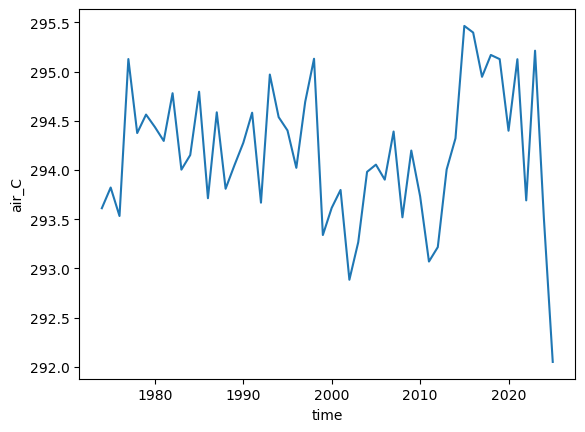

In [7]:
daily_max.resample(time='YE').mean().plot()

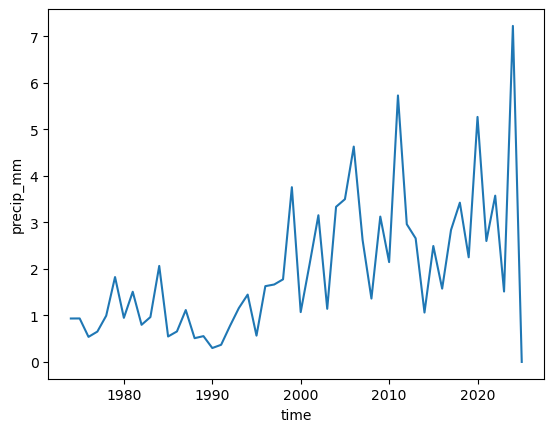

In [9]:
daily_max_pr = ds['precip_mm'].resample(time='1D').sum()
daily_max_pr.resample(time='YE').mean().plot()

In [29]:
noon_exact = ds['wind_speed']